In [1]:
import xarray as xr
from calculate_exposure_to_haz import INPUT_DIR, EXPOSURES_DIR, get_exposures, write_impact
import numpy as np
exposures_dict = get_exposures(haz_type='HW')

In [2]:
import pandas as pd
import numpy as np
from climada.hazard import Hazard
import xarray as xr
from calculate_exposure_to_haz import *

# Rename columns

# Extract years from the `time` dimension
unique_years = np.arange(2003,2023)

yearly_hazards = {}

for year in unique_years:
    file = INPUT_DIR / f"heatwave_days_era5_0.25/heatwaves_monthly/indicator_{year}.nc"

    yearly_hazard = xr.open_dataset(file)
    yearly_hazard = yearly_hazard.rename({"month":"time"})
    yearly_hazard['longitude'] = yearly_hazard['longitude'].where(yearly_hazard['longitude'] <= 180, yearly_hazard['longitude'] - 360)

    # Convert it into a hazard
    yearly_hazard = Hazard.from_xarray_raster(yearly_hazard, hazard_type='HW', intensity_unit='days', intensity='heatwaves_days')
    # Append the hazard to the list
    yearly_hazards[year] = yearly_hazard


<GeoAxes: title={'center': 'HW max intensity at each point'}>

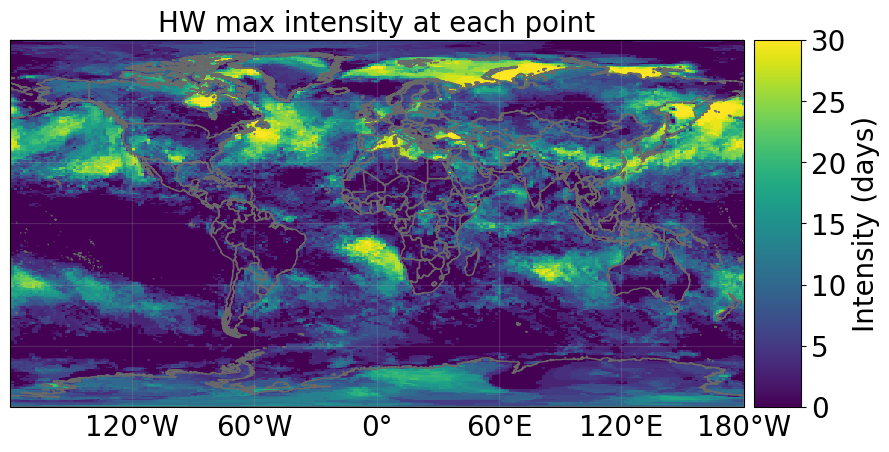

In [3]:
yearly_hazards[year].plot_intensity(0)

In [4]:
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet

impf_set = ImpactFuncSet()

impfhw = ImpactFunc()
impfhw.id = 1
impfhw.haz_type = 'HW'
impfhw.name = 'Step function hw'
impfhw.intensity_unit = ''
impfhw.intensity = np.array([0, 1])
impfhw.mdd = np.array([0, 1])
impfhw.paa = np.ones(impfhw.intensity.shape)
impfhw.check()
impf_set.append(impfhw)

<GeoAxes: title={'center': 'HW max intensity at each point'}>

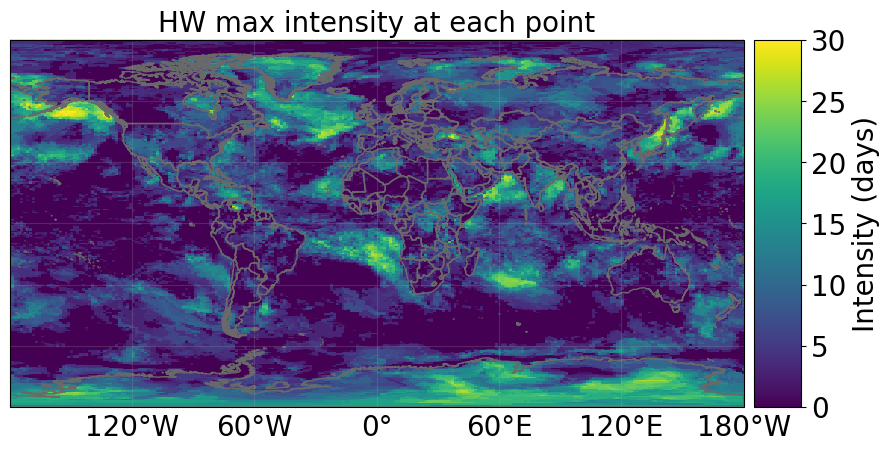

In [5]:
yearly_hazards[2005].plot_intensity(0)

In [6]:
from climada.engine import Impact, ImpactCalc

impact_dict={age:{year:ImpactCalc(exposures_dict[age][str(year)], impf_set, yearly_hazards[int(year)]).impact(save_mat=True) for year in exposures_dict[age]} for age in exposures_dict}
for age in impact_dict:
    for year in impact_dict[age]:
        impact_dict[age][year].tot_value=0


impact_dict_no_change_vuln_pop={age:{year:ImpactCalc(exposures_dict[age]['2003'], impf_set, yearly_hazards[int(year)]).impact(save_mat=True) for year in exposures_dict[age]} for age in exposures_dict}
for age in impact_dict_no_change_vuln_pop:
    for year in impact_dict_no_change_vuln_pop[age]:
        impact_dict_no_change_vuln_pop[age][year].tot_value=0



2024-08-22 11:34:16,221 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-22 11:34:16,223 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-22 11:34:16,224 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-22 11:34:16,224 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-22 11:34:16,224 - climada.engine.impact - WARNING - The 

In [7]:
impact_concat = {}
impact_concat_no_change_vuln_pop = {}
for age in impact_dict_no_change_vuln_pop:
    impact_concat[age] = Impact.concat(list(impact_dict[age].values()),reset_event_ids=True)
    impact_concat_no_change_vuln_pop[age] = Impact.concat(list(impact_dict_no_change_vuln_pop[age].values()),reset_event_ids=True)

2024-08-22 11:36:10,555 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-22 11:36:10,556 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-22 11:36:10,556 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-22 11:36:10,557 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-22 11:36:10,557 - climada.engine.impact - WARNING - The 

In [9]:
for age in impact_concat_no_change_vuln_pop:
    write_impact(impact_concat[age], 'HW', age)
    write_impact(impact_concat_no_change_vuln_pop[age], 'HW_ec', age)